# Studying Static and Dynamic CallGraphs

## Defining util functions

In [5]:
import json

## get callers names but only keep the ones that are not a sub name of another caller
def get_orig_keys(calls_dict):
    orig_keys = []
    for c_key in calls_dict:
        for key in calls_dict:
            if c_key != key:
                if key in c_key:
                    break
        else:
            orig_keys.append(c_key)
    return orig_keys

In [6]:
## extract longest common substring
def longest_common_substring(strings):
    if not strings:
        return ""

    def find_common_prefix(s1, s2):
        common_prefix = ""
        min_len = min(len(s1), len(s2))
        for i in range(min_len):
            if s1[i] == s2[i]:
                common_prefix += s1[i]
            else:
                break
        return common_prefix

    longest_common = strings[0]

    for i in range(1, len(strings)):
        longest_common = find_common_prefix(longest_common, strings[i])

    return longest_common

In [7]:
## Reconstructing the call graph with simpler names
def construct_graph(dynapyt_graph, orig_keys):
    new_graph = {}
    replacement_rules = {}
    processed_keys = []
    for key in orig_keys:
        calls = dynapyt_graph[key]
        new_graph[key] = {k: {} for k in calls}
        for k in dynapyt_graph:
            if key in k and k not in orig_keys and k not in processed_keys:
                longest_sub_root = ""
                for c in new_graph[key]:
                    if c in k and len(c) > len(longest_sub_root):
                        longest_sub_root = c
                if longest_sub_root == "":
                    new_graph[k] = {m:{} for m in dynapyt_graph[k]}
                else:
                    new_graph[key][longest_sub_root] = {m:{} for m in dynapyt_graph[k]}
                    
                processed_keys.append(k)

    return new_graph

In [8]:
def dedup(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [9]:
import re
## simplifying PyCG callgraph to become compatible with the syntax of CallGraph
def simplify_pycg_graph(pycg_graph, replace_list=[]):
    new_graph = {}

    for k in pycg_graph:
        new_k = re.sub("<Mock id='[0-9]+'>", "mock Mock",
            re.sub(
            "\(<Mock id='[0-9]+'>\)", "", 
            re.sub(
                "<lambda[0-9]+>", 
                "<lambda>", 
                k.replace("<builtin>", "builtins").replace(".__init__", "").replace("_enter__", "")
            ).replace(".py.", "")))
        
        new_v = [re.sub("<Mock id='[0-9]+'>", "mock Mock",
                re.sub("\(<Mock id='[0-9]+'>\)", "",
                re.sub("<lambda[0-9]+>", 
                       "<lambda>", 
                       m.replace("<builtin>", "builtins").replace(".__init__", "").replace("__enter__.", "").replace("__enter__", "").replace("_enter__.", "").replace("_enter__", "").replace(".py.", "").replace("flask_api.", ""))))
                for m in pycg_graph[k]]
        if new_k in new_graph:
            new_graph[new_k] += new_v
        else:
            new_graph[new_k] = new_v 
    
    final_graph = {}
    for k, v in new_graph.items():
        if k.endswith(".py"):
            final_graph[k[:-3]] = new_graph[k]
        else:
            final_graph[k] = new_graph[k]

    final_graph_2 = {}
    for k, v in final_graph.items():
        new_k = k if k[0] != "_" else k[1:]
        new_v = [".".join([x[1:] if x.startswith("_") else x for x in e.split(".")]) for e in v]
        if new_k in final_graph_2:
            final_graph_2[new_k] += new_v
        else:
            final_graph_2[new_k] = new_v

    final_graph_3 = {}
    
    for k, v in final_graph_2.items():
        new_k = ".".join(dedup(k.split(".")))
        new_v = [".".join(dedup(e.split("."))) for e in v]
        if new_k in final_graph_3:
            final_graph_3[new_k] += new_v
        else:
            final_graph_3[new_k] = new_v
    #final_graph_3 = final_graph_2


    final_graph_4 = {}
    
    for k, v in final_graph_3.items():
        new_k = k
        new_v = v
        for r in replace_list:
            new_k = new_k.replace(r[0], r[1])
            new_v = [e.replace(r[0], r[1]) for e in new_v]

        if new_k in final_graph_4:
            final_graph_4[new_k] += new_v
        else:
            final_graph_4[new_k] = new_v
    
    for k in final_graph_4:
        final_graph_4[k] = list(set(final_graph_4[k]))

        
    return final_graph_4

In [10]:
def prepare_pycg_graph(path_to_json, replace_list=[]):
    with open(path_to_json) as pcgg:
        pcg_graph = json.load(pcgg)

    simple_pycg_graph = simplify_pycg_graph(pcg_graph, replace_list=replace_list)
    #orig_keys = get_orig_keys(simple_pycg_graph)
    #c_graph = construct_graph(simple_pycg_graph, orig_keys)
    #return c_graph
    return simple_pycg_graph

In [11]:
def prepare_dynapyt_graph(path_to_json, project_number, project_folder, replace_list=[]):
    print(replace_list)
    with open(path_to_json) as dout:
        dnpt_graph = json.load(dout)

    new_dnpt_graph = {}
    for key in dnpt_graph:
        new_dnpt_graph[key.replace(".DyPyBench.temp.project{}.{}.".format(project_number, project_folder), "").replace(".DyPyBench.temp.project{}.".format(project_number), "")] = [
            v.replace("{}.".format(project_folder), "").replace(".case.", ".") for v in dnpt_graph[key]]
        
    print(len(new_dnpt_graph))
    simple_dnpt_graph = simplify_pycg_graph(new_dnpt_graph, replace_list=replace_list)
    print(len(simple_dnpt_graph))
    #orig_keys = get_orig_keys(simple_dnpt_graph)
    #graph_comp = construct_graph(simple_dnpt_graph, orig_keys)
    #return graph_comp
    return simple_dnpt_graph

## Postprocess and munual inspection

In [12]:
from thefuzz import fuzz
from thefuzz import process

In [13]:
def print_similar_keys(graph_comp, c_graph):
    for key in graph_comp:
        if key not in c_graph:
            ext = process.extract(key, set(c_graph.keys()), limit=2)
            print(key, ext)
        

In [14]:
def print_similar_values(graph_comp, c_graph):
    all_pycg = []
    for k, v in c_graph.items():
        all_pycg.extend([" ".join(e.split(".")) for e in v])

    all_dynapyt = []
    for k, v in graph_comp.items():
        all_dynapyt.extend([" ".join(e.split(".")) for e in v])
    
    for c1 in all_dynapyt:
        if c1 not in all_pycg:
            ext = process.extract(c1, set(all_pycg) , limit=2)
            print(c1, ext)

In [15]:
def remove_location(dynapyt_file):
    with open(dynapyt_file) as df:
        d_graph = json.load(df)


    new_graph = {}
    for k, v in d_graph.items():
        new_graph[k] = [e[:e.find("###")] for e in v]

    return new_graph

In [16]:
standards = [list, set, dict, str, bytes, int, float]

funcs = []

for s in standards:
    funcs += [e for e in dir(s) if not e.startswith("_")]

## Project 1 (Example)

In [30]:
rs_graph = remove_location("pycg_output/project1_pycg.json")

with open("pycg_output/pycg_1.json", "w") as dpt:
    json.dump(rs_graph, dpt)

In [31]:
pycg_graph = prepare_pycg_graph(
    "pycg_output/pycg_project1.json", 
    replace_list=[
        ("grab.", ""),
        ("threading", "thread")
        ])

dynapyt_graph = prepare_dynapyt_graph(
    "DynaPyt_output/dynapyt_1.json", 
    1, "grab", 
    replace_list=[
        ("unicodec.normalization", "unicodec"),
        ("unicodec.main", "unicodec"),
        ("stat.Stat", "Stat"),
        ("threading", "thread")
        ])
len(set(dynapyt_graph.keys()) & set(pycg_graph.keys())) / (len(set(dynapyt_graph.keys())))

[('unicodec.normalization', 'unicodec'), ('unicodec.main', 'unicodec'), ('stat.Stat', 'Stat'), ('threading', 'thread')]
122
122


0.9918032786885246

In [33]:
print_similar_keys(dynapyt_graph, pycg_graph)

spider.service.base.ServiceWorker.wrapper [('spider.service.base.ServiceWorker', 95), ('spider.service.base.ServiceWorker.worker_callback_wrapper', 95)]


In [34]:
all_pycg = []
for k, v in pycg_graph.items():
    if k in dynapyt_graph.keys():
        all_pycg.extend([" ".join(e.split(".")) for e in v])

all_dynapyt = []
for k, v in dynapyt_graph.items():
    all_dynapyt.extend([" ".join(e.split(".")) for e in v])

In [35]:
len(set(all_dynapyt)& set(all_pycg))/len(set(all_dynapyt))

0.5555555555555556

In [36]:
len(set(all_dynapyt)& set(all_pycg))

130

In [38]:
exclude = []
for ad in all_dynapyt:
    ads = ad.split(" ")
    for f in funcs:
        if ads[-1] ==  f:
            exclude.append(ad)
            break

In [39]:
dyna_edges = [(k, e) for k,v in dynapyt_graph.items() for e in v]
pycg_edges = [(k, e) for k,v in pycg_graph.items() for e in v]

len(set(dyna_edges) & set(pycg_edges))/len(dyna_edges)

0.5803814713896458

# Constructing Comparision for all Projects

In [84]:
projects = [1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 28, 29, 31, 32, 33, 35, 36, 37, 38, 45, 46, 50, 52, 53, 56, 57, 58]

In [85]:
not_both = 0
not_caller = 0
not_callee = 0
both_in = 0
count_pycg_edges = 0
d_callers = 0
c_callers = 0
d_callees = 0
c_callees = 0
d_edges = 0
c_edges = 0
and_callers = 0
and_callees = 0
and_edges = 0
uncommon_callers = []
for p_number in projects:
    pycg_graph = prepare_pycg_graph("pycg_output/pycg_project{}.json".format(p_number), replace_list=[])
    dynapyt_graph = prepare_dynapyt_graph("DynaPyt_output/dynapyt_{}.json".format(p_number), p_number, "structlog.", 
                                        replace_list=[])
    len(set(dynapyt_graph.keys()) & set(pycg_graph.keys())) / (len(set(dynapyt_graph.keys())))

    all_pycg = []
    for k, v in pycg_graph.items():
        if k in dynapyt_graph.keys():
            all_pycg.extend([" ".join(e.split(".")) for e in v])

    all_dynapyt = []
    for k, v in dynapyt_graph.items():
        all_dynapyt.extend([" ".join(e.split(".")) for e in v])

    dyna_edges = [(k, e) for k,v in dynapyt_graph.items() for e in v]
    pycg_edges = [(k, e) for k,v in pycg_graph.items() for e in v]
    count_pycg_edges += len(set(pycg_edges))
    dyna_diff_edges = set(dyna_edges) - (set(dyna_edges)&set(pycg_edges))
    pycg_diff_edges = set(pycg_edges) - (set(dyna_edges)&set(pycg_edges))

    d_callers += len(set(dynapyt_graph.keys()))
    c_callers += len(set(pycg_graph.keys()))
    d_callees += len(set(all_dynapyt))
    c_callees += len(set(all_pycg))
    d_edges += len(set(dyna_edges))
    c_edges += len(set(pycg_edges))
    and_callers += len(set(dynapyt_graph.keys()) & set(pycg_graph.keys()))
    and_callees += len(set(all_dynapyt)& set(all_pycg))
    and_edges += len(set(dyna_edges)&set(pycg_edges))
    uncommon_callers.extend(list(set(dynapyt_graph.keys()) - (set(dynapyt_graph.keys())& set(pycg_graph.keys()))))
    for e in pycg_diff_edges:
        if e[0] not in dynapyt_graph.keys() and e[1] not in all_dynapyt:
            not_both += 1
        elif e[0] not in dynapyt_graph.keys():
            not_caller += 1
        elif e[1] not in all_dynapyt:
            not_callee += 1
        else:
            both_in += 1

[]
122
122
[]
51
51
[]
40
40
[]
13
13
[]
74
74
[]
18
18
[]
85
85
[]
9
9
[]
48
48
[]
8
8
[]
46
46
[]
45
45
[]
18
18
[]
103
103
[]
38
38
[]
39
39
[]
17
17
[]
9
9
[]
52
52
[]
27
27
[]
151
151
[]
211
211
[]
81
81
[]
23
23
[]
146
146
[]
28
28
[]
61
60
[]
199
199
[]
23
23
[]
57
56
[]
46
46
[]
7
7
[]
14
14
[]
20
20
[]
19
19
[]
74
74
[]
13
13


In [86]:
print(not_both, not_caller, not_callee, both_in)

45915 81 11177 17


In [87]:
print(d_callers, c_callers, d_callees, c_callees, d_edges, c_edges, and_callers, and_callees, and_edges)

2033 33363 3712 9877 6278 60133 1938 1637 2943


In [75]:
count_pycg_edges

60133

# Constructing Plots of Section 4.1

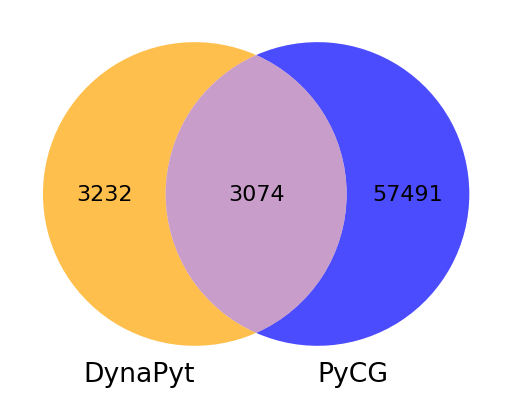

In [2]:
from matplotlib_venn import venn2_unweighted 
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

# Edges
venn2_unweighted(subsets = (6306 - 3074, 
                        60565 - 3074, 
                        3074),
                set_labels = ('DynaPyt', 
                            'PyCG'),
                set_colors=("orange",
                            "blue"),alpha=0.7)
plt.show()

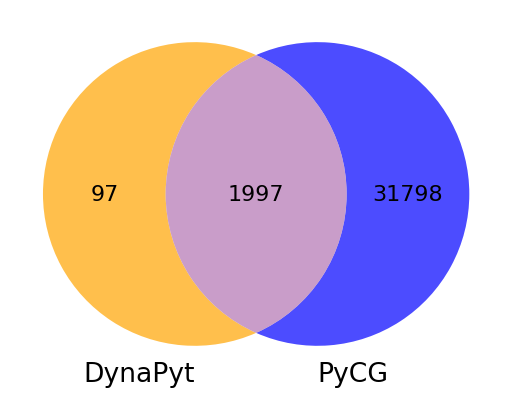

In [3]:
# Callers
venn2_unweighted(subsets = (2094 - 1997, 
                        33795 - 1997, 
                        1997),
                set_labels = ('DynaPyt', 
                            'PyCG'),
                set_colors=("orange",
                            "blue"),alpha=0.7)
plt.show()

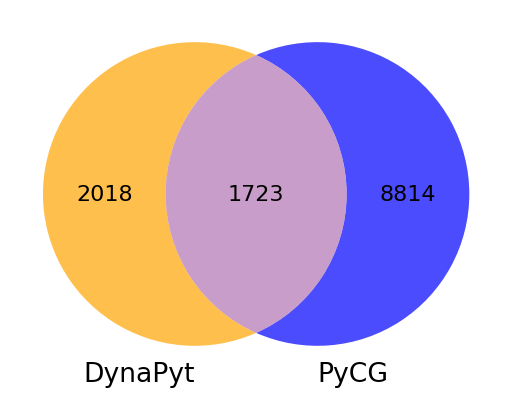

In [4]:
# Callees
venn2_unweighted(subsets = (3741 - 1723, 
                        10537 - 1723, 
                        1723),
                set_labels = ('DynaPyt', 
                            'PyCG'),
                set_colors=("orange",
                            "blue"),alpha=0.7)
plt.show()

In [ ]:
2049 33795 3741 10537 6306 60565 1997 1723 3074

In [67]:
projects = [1, 2, 3, 4, 5,
            6, 7, 8, 9, 10,
            11, 12, 13, 14, 15,
            16, 18, 19, 20, 21,
             22, 23, 24, 25, 26,
             28,27, 29, 30,
            31, 32, 33, 35, 36,
            37, 38, 39, 40, 41,
            45, 46, 47, 48, 50, 
            52, 53, 56, 57, 58]

In [69]:
not_both = 0
not_caller = 0
not_callee = 0
both_in = 0
count_pycg_edges = 0
d_callers = 0
c_callers = 0
d_callees = 0
c_callees = 0
d_edges = 0
c_edges = 0
and_callers = 0
and_callees = 0
and_edges = 0
uncommon_callers = []
for p_number in projects:
    dynapyt_graph = prepare_dynapyt_graph("DynaPyt_output/dynapyt_{}.json".format(p_number), p_number, "structlog.", 
                                        replace_list=[])


    all_dynapyt = []
    for k, v in dynapyt_graph.items():
        all_dynapyt.extend([" ".join(e.split(".")) for e in v])

    dyna_edges = [(k, e) for k,v in dynapyt_graph.items() for e in v]

    d_callers += len(set(dynapyt_graph.keys()))
    d_callees += len(set(all_dynapyt))
    d_edges += len(set(dyna_edges))

[]
122
122
[]
400
390
[]
51
51
[]
40
40
[]
104
103
[]
13
13
[]
74
74
[]
18
18
[]
85
85
[]
136
136
[]
9
9
[]
48
48
[]
8
8
[]
35
35
[]
45
45
[]
18
18
[]
103
103
[]
38
38
[]
39
39
[]
49
49
[]
17
17
[]
9
9
[]
52
52
[]
27
27
[]
54
54
[]
151
151
[]
75
75
[]
211
211
[]
65
63
[]
81
81
[]
23
23
[]
146
146
[]
28
28
[]
61
60
[]
199
199
[]
23
23
[]
2
2
[]
52
52
[]
33
33
[]
57
56
[]
46
46
[]
72
72
[]
27
27
[]
7
7
[]
14
14
[]
20
20
[]
19
19
[]
74
74
[]
13
13
